
# kaggleのデータセットを用いてモデルを構築する

### 目的：クラウドファンディングが成功するかを予測するモデルを構築する
### Kickstarter Projects URL:https://www.kaggle.com/kemical/kickstarter-projects

・利用するデータ「ks-projects-201801.csv」（データ数：378,661行15列）

| 列 | 項目 | 項目名 | 欠損有無 | 利用有無 |
| :--- | :--- | :--- | :---: | :---: |
|  1 | ID| 識別ID | - | × |
|  2 | name |名称 | 欠損あり | × |
|  3 | category |カテゴリ | - | ×※主なカテゴリを使うため除外 |
|  4 | main_category |主なカテゴリ | - | ○ |
|  5 | currency |使用通貨 | - | ○ |
|  6 | deadline |締切日時 | - | ○※期間算出用 |
|  7 | goal |目標調達資金額 | - | ×※usd_goal_realを使うため除外 |
|  8 | launched |開始日時 | - | ○※期間算出用 |
|  9 | pledged |集まった資金 | - | × |
| 10 | state |プロジェクトの状態 | - | ○※成功と失敗のみ抽出 |
| 11 | backers |支援者数 | - | × |
| 12 | country|国 | - | ○ |
| 13 | usd_pledged |集まった資金（米ドル） | 欠損あり | × |
| 14 | usd_pledged_real |集まった資金（米ドル） | - | × |
| 15 | usd_goal_real |目標金額（米ドル） | - | ○ |

In [66]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

# 警告非表示
import warnings
warnings.filterwarnings('ignore')

In [67]:
# データセット読込
df= pd.read_csv('./ks-projects-201801.csv')

#print("\n▼ 欠損項目を確認")
#print(df.isnull().sum())

#print("\n▼ 各項目の項目値を確認")
#print(df['state'].unique())

# 欠損項目および不要項目を削除
df = df.drop(['ID','name','goal','usd pledged','category'], axis=1)
# 事前に予測できない項目を削除
df = df.drop(['backers','pledged','usd_pledged_real'], axis=1)

# 開始日時と締切日時から期間(period)を算出
df['deadline'] = pd.to_datetime(df['deadline'], errors = 'coerce')
df['launched'] = pd.to_datetime(df['launched'], errors = 'coerce')
df['period'] = (df['deadline'] - df['launched']).dt.days
df = df.drop(['launched','deadline'], axis=1)

# 状態が成功または失敗のデータを抽出
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')]

# 状態が成功ならば（1：True），失敗であれば（0：False）に変更
df['state'] = df['state'] == 'successful'

# ダミー変換
df = pd.get_dummies(df, columns=['main_category', 'currency', 'country'])

# データを標準化
scaler = StandardScaler()        
df['usd_goal_real'] = scaler.fit_transform(df.loc[:, ['usd_goal_real']])
df['period'] = scaler.fit_transform(df.loc[:, ['period']])

df.index.name="id"

print("\n▼ csvデータ確認")
display(df.head())

print("\n▼ データの基本統計量確認")
df.describe()



▼ csvデータ確認


,state,usd_goal_real,period,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
id,,,,,,,,,,,,,,,,,,,,,
0,False,-0.036049,1.969990,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,False,-0.010379,2.048648,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,False,0.003147,0.868782,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,False,-0.032924,-0.311084,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,True,0.007656,0.082205,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1



▼ データの基本統計量確認


,usd_goal_real,period,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
count,3.316750e+05,3.316750e+05,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,...,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000
mean,4.508065e-16,-2.622543e-15,0.077308,0.029782,0.023571,0.010773,0.076472,0.059622,0.170429,0.066493,...,0.000069,0.000172,0.004254,0.000633,0.007269,0.001755,0.003841,0.004550,0.001369,0.788000
std,1.000002e+00,1.000002e+00,0.267079,0.169986,0.151709,0.103231,0.265753,0.236785,0.376010,0.249142,...,0.008327,0.013108,0.065085,0.025155,0.084949,0.041853,0.061858,0.067297,0.036972,0.408725
min,-3.743254e-02,-2.592157e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-3.562901e-02,-3.110835e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,-3.292369e-02,-3.110835e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,-2.390597e-02,1.608628e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.499826e+02,4.565695e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


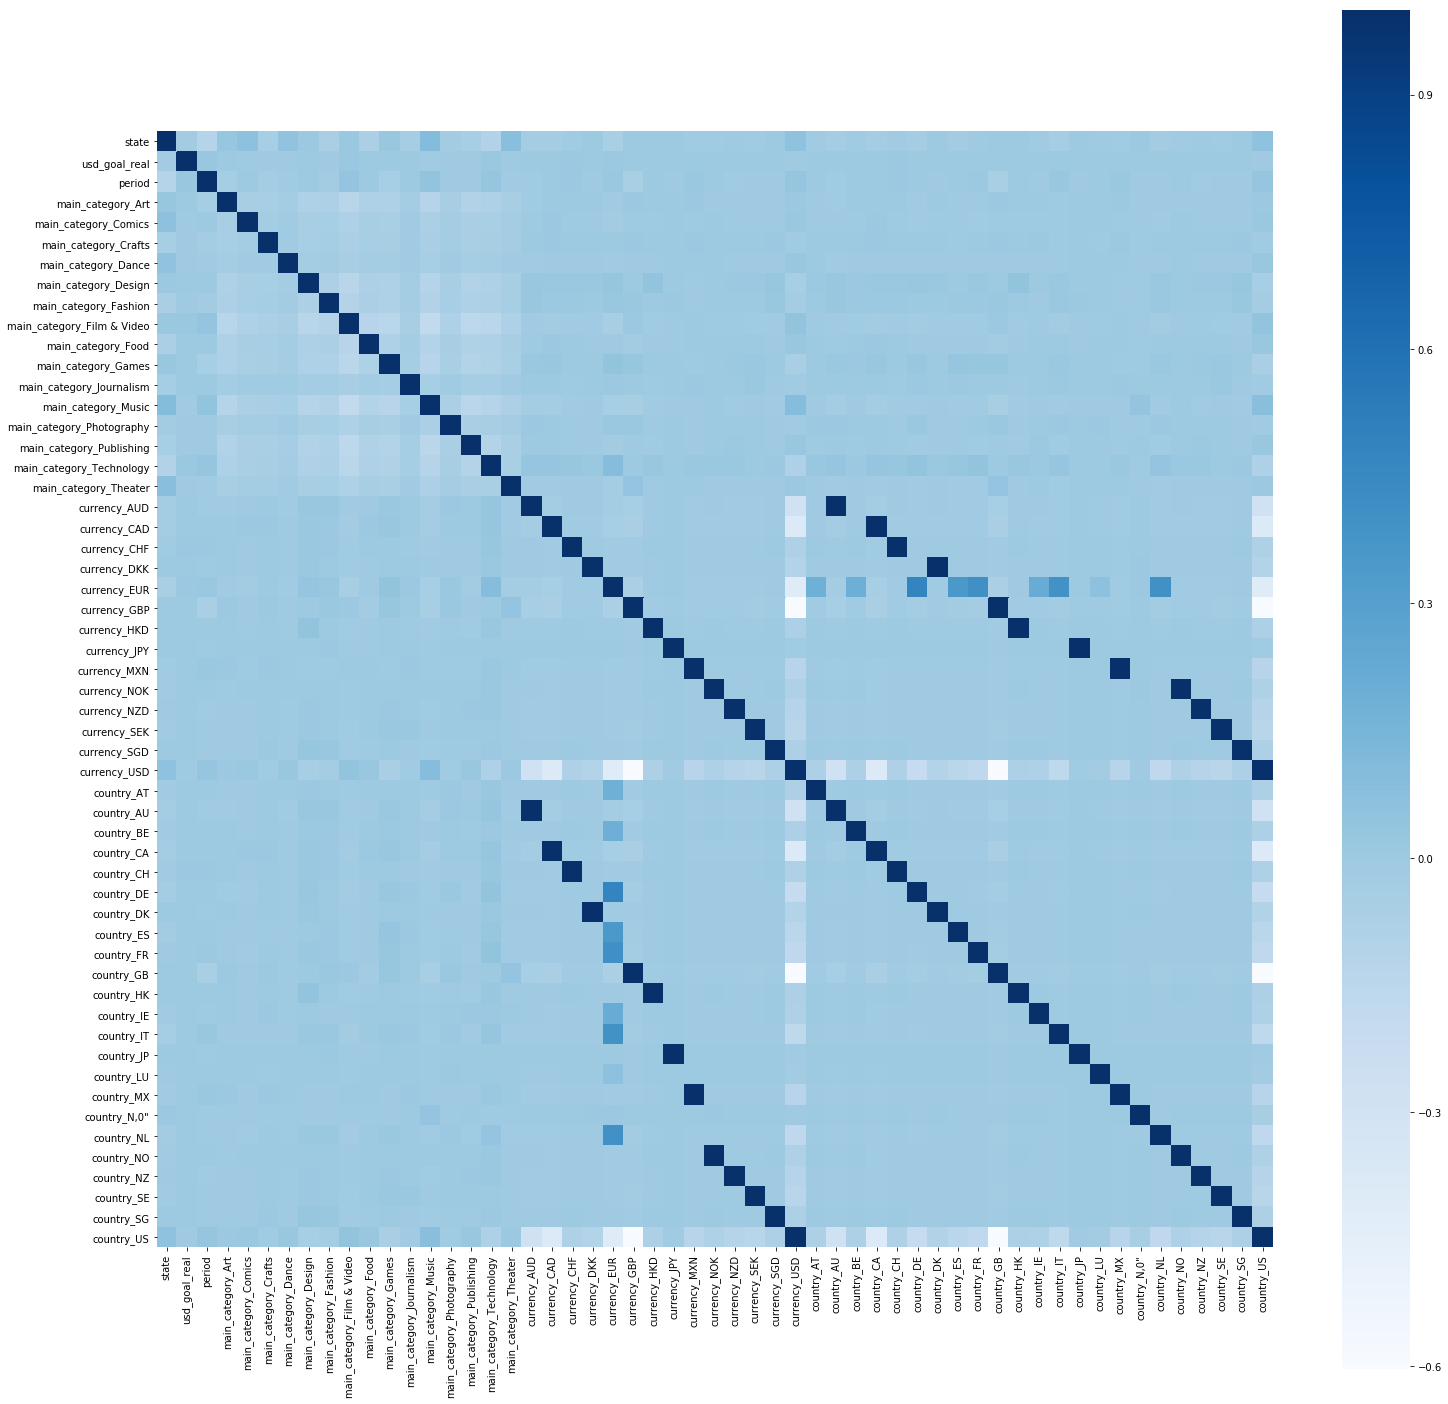

In [62]:
# 相関係数をヒートマップにして可視化
df.corr()
plt.figure(figsize=(25, 25)) 
sns.heatmap(df.corr(), square=True, cmap='Blues')
plt.show()

In [68]:
X = df.drop('state', axis=1).values # 説明変数
y = df['state'].values              # 目的変数

# ロジスティック回帰モデル生成
clf = SGDClassifier(loss='log',           # ロジスティック回帰を指定
                    penalty='none',       # 正則化を入れる場合はL1､L2→Day2で実施
                    max_iter=10000,       # 繰り返し計算時の強制的終了値、誤差が収束すれば利用しない。
                    fit_intercept=True,   # 切片を有効にするかどうか
                    random_state=1234,    # 乱数のシード
                    tol=1e-3              # 収束する誤差の指定
                   )

# 学習
clf.fit(X, y)

# リスト型へ変換
n_features = list(df.drop('state', axis=1).columns)
fti = np.reshape(clf.coef_[0], -1).tolist()

print("\n▼ 各重みを表示")
print('w0 = {:.3f}'.format(clf.intercept_[0]))
for i, feature in enumerate(n_features):
    print(feature.ljust(30, ' ') + "---->   w{:.0f} = {:.3f}".format(i + 1, fti[i]))
    #print('\t{0:30s} : {1:>.6f}'.format(feature, fti[i]))

        


▼ 各重みを表示
w0 = -0.904
usd_goal_real                 ---->   w1 = -17.741
period                        ---->   w2 = -0.201
main_category_Art             ---->   w3 = -0.010
main_category_Comics          ---->   w4 = 0.596
main_category_Crafts          ---->   w5 = -0.767
main_category_Dance           ---->   w6 = 0.842
main_category_Design          ---->   w7 = 0.131
main_category_Fashion         ---->   w8 = -0.661
main_category_Film & Video    ---->   w9 = 0.162
main_category_Food            ---->   w10 = -0.540
main_category_Games           ---->   w11 = 0.176
main_category_Journalism      ---->   w12 = -0.818
main_category_Music           ---->   w13 = 0.367
main_category_Photography     ---->   w14 = -0.414
main_category_Publishing      ---->   w15 = -0.315
main_category_Technology      ---->   w16 = -0.497
main_category_Theater         ---->   w17 = 0.844
currency_AUD                  ---->   w18 = -0.193
currency_CAD                  ---->   w19 = -0.023
currency_CHF            

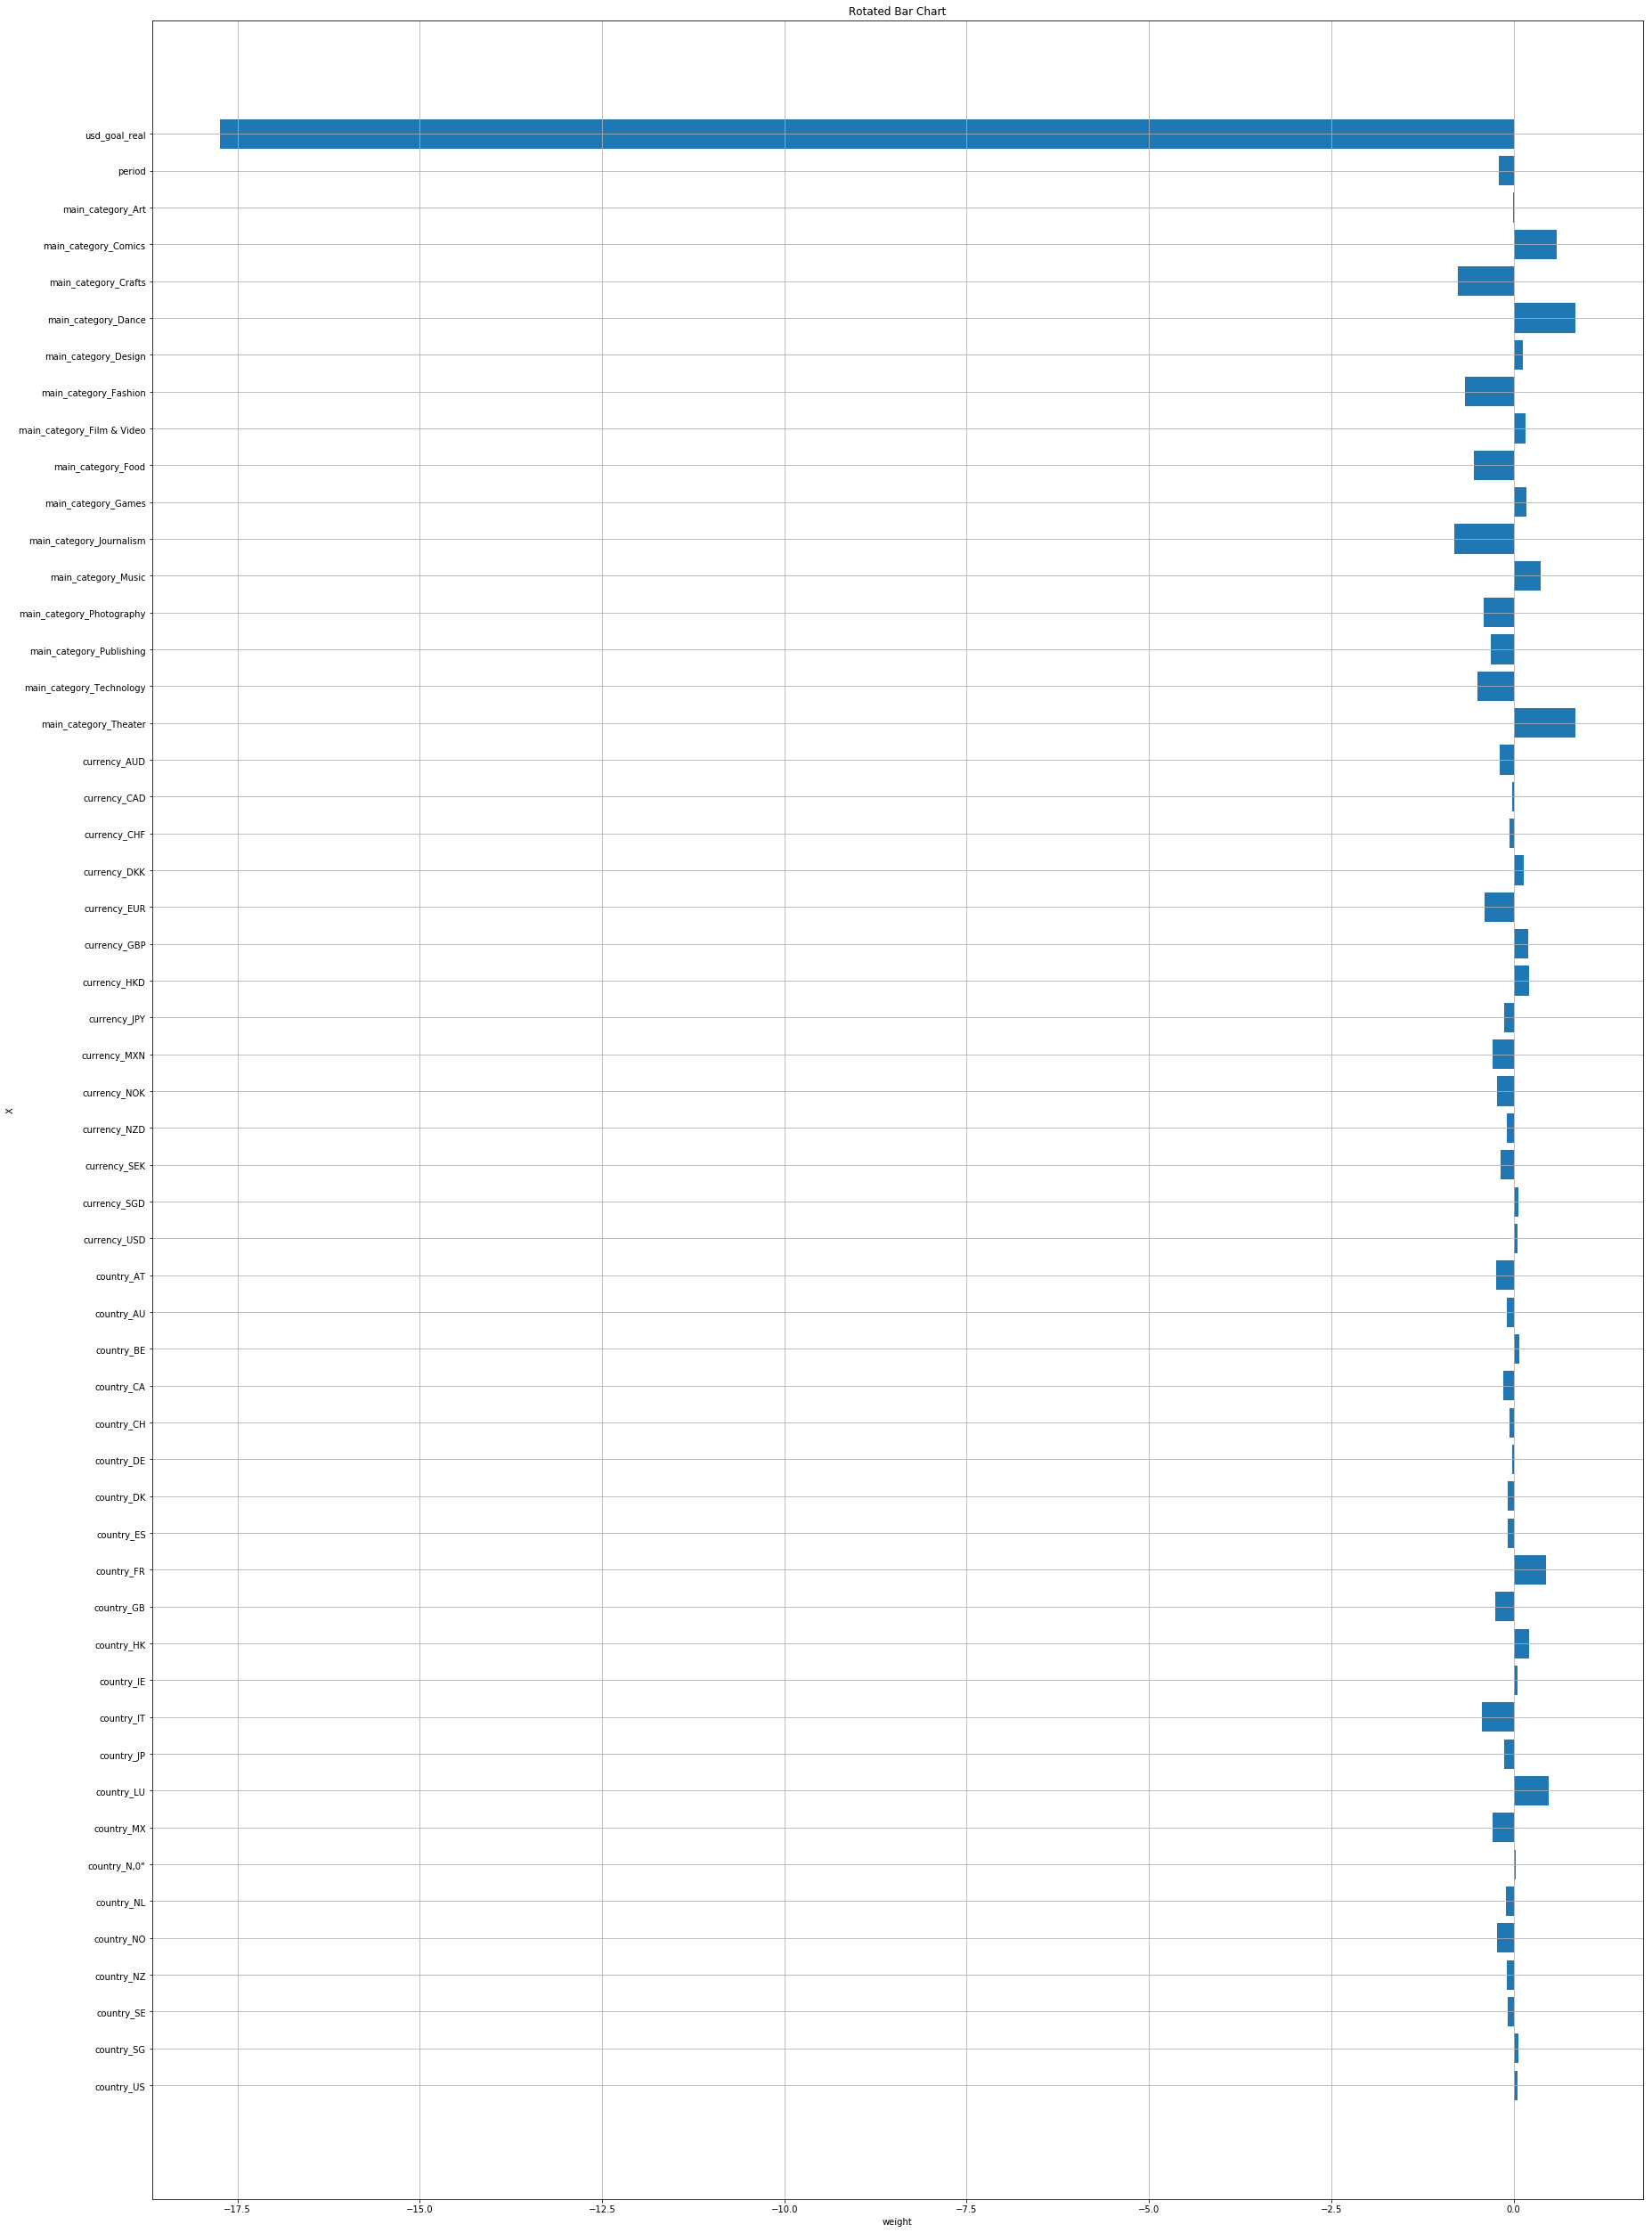

In [69]:
# グラフ化  
plt.figure(figsize=(30, 45))
plt.barh(np.arange(len(n_features))[::-1], fti, align='center')
plt.yticks(np.arange(len(n_features))[::-1], n_features)
plt.title('Rotated Bar Chart')
plt.xlabel('weight')
plt.ylabel('X')
plt.grid()
plt.show()

In [70]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# 成功に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

対数尤度 = -12.234
正答率 = 64.578%
適合率（Precision） = 66.431%
再現率（Recall） = 82.033%
F1値（F1-score） = 73.412%


,予測 = 失敗,予測 = 成功
正解 = 失敗,162194,35525
正解 = 成功,81961,51995
